In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

Global seed set to 0


In [2]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


In [3]:
%load_ext autoreload
%autoreload 2

# Load preprocessed data

We recommend using raw counts for scRNA-seq and TF-IDF normalized expression for ATAC-seq. You can also input binarized counts for ATAC, but normalized expression seems to integrate a bit better.

In [4]:
rna = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/10xpbmc10k-2020/10x_2020_rna_hvg.h5ad')
atac = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/10xpbmc10k-2020/10x_2020_atac.h5ad')

In [5]:
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'count'

In [6]:
atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'cell_type_l2'
    layers: 'binary'

# Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. Here in this example we have 1 paired RNA-ATAC dataset, hence we input 2 anndata objects, 1 for rna modality, 1 for atac modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- if there are batch effects in one dataset, please split the data into batches beforehand, becaues the model treats each input anndata object as 1 batch

If we had more unpaired data here, e.g. 1 paired RNA-ATAC dataset (```rna1```, ```atac1```) and 2 other RNA datasets (```rna2```, ```rna3```), we would have to first subset the RNA modality to the set of common genes (and then possibly to highly variable genes). Then we would need to specify
```adata = [[rna1, rna2, rna3], [atac]]``` and ```groups = [[0, 1, 2], [0]]```.

In [7]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [atac]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],          # 
    layers = [['count'], [None]]  # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count', 'binary'

Sanity check: in case of multiple datasets `len(adata)` should be equal `len(rna1) + len(rna2) + len(rna3)`.

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [8]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000 # how many features in the rna-seq modality
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10000 cells, 44086 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["sex"],
continuous_covariate_keys: ["age"]
```

# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. If using normalized counts for ATAC-seq, use MSE, if binalized use BCE (`'bce'`).

In [9]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 40086], # how many features per modality
    losses=['nb', 'mse'],           # what losses to use for each modality
    loss_coefs={'kl': 1e-3,
               'integ': 0}       # depending on the datasets, might need to fine-tune loss coeficients, done here
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [10]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 1/200 [00:01<05:23,  1.63s/it, loss=1.13e+04, v_num=1]

Metric elbo_validation improved. New best score: 8913.104


Epoch 2/200:   1%|          | 2/200 [00:03<05:32,  1.68s/it, loss=8.83e+03, v_num=1]

Metric elbo_validation improved by 2044.387 >= min_delta = 0.0. New best score: 6868.717


Epoch 3/200:   2%|▏         | 3/200 [00:05<05:33,  1.70s/it, loss=7.75e+03, v_num=1]

Metric elbo_validation improved by 788.762 >= min_delta = 0.0. New best score: 6079.956


Epoch 4/200:   2%|▏         | 4/200 [00:06<05:32,  1.70s/it, loss=7.15e+03, v_num=1]

Metric elbo_validation improved by 323.741 >= min_delta = 0.0. New best score: 5756.215


Epoch 5/200:   2%|▎         | 5/200 [00:08<05:31,  1.70s/it, loss=6.81e+03, v_num=1]

Metric elbo_validation improved by 183.112 >= min_delta = 0.0. New best score: 5573.103


Epoch 6/200:   3%|▎         | 6/200 [00:10<05:30,  1.71s/it, loss=6.59e+03, v_num=1]

Metric elbo_validation improved by 92.951 >= min_delta = 0.0. New best score: 5480.152


Epoch 7/200:   4%|▎         | 7/200 [00:11<05:30,  1.71s/it, loss=6.39e+03, v_num=1]

Metric elbo_validation improved by 61.468 >= min_delta = 0.0. New best score: 5418.684


Epoch 8/200:   4%|▍         | 8/200 [00:13<05:28,  1.71s/it, loss=6.24e+03, v_num=1]

Metric elbo_validation improved by 37.052 >= min_delta = 0.0. New best score: 5381.631


Epoch 9/200:   4%|▍         | 9/200 [00:15<05:27,  1.71s/it, loss=6.13e+03, v_num=1]

Metric elbo_validation improved by 23.498 >= min_delta = 0.0. New best score: 5358.134


Epoch 10/200:   5%|▌         | 10/200 [00:17<05:25,  1.71s/it, loss=6.04e+03, v_num=1]

Metric elbo_validation improved by 17.375 >= min_delta = 0.0. New best score: 5340.758


Epoch 11/200:   6%|▌         | 11/200 [00:18<05:24,  1.71s/it, loss=6e+03, v_num=1]   

Metric elbo_validation improved by 13.531 >= min_delta = 0.0. New best score: 5327.228


Epoch 12/200:   6%|▌         | 12/200 [00:20<05:21,  1.71s/it, loss=5.89e+03, v_num=1]

Metric elbo_validation improved by 9.102 >= min_delta = 0.0. New best score: 5318.125


Epoch 13/200:   6%|▋         | 13/200 [00:22<05:27,  1.75s/it, loss=5.88e+03, v_num=1]

Metric elbo_validation improved by 8.068 >= min_delta = 0.0. New best score: 5310.058


Epoch 14/200:   7%|▋         | 14/200 [00:24<05:28,  1.76s/it, loss=5.81e+03, v_num=1]

Metric elbo_validation improved by 4.772 >= min_delta = 0.0. New best score: 5305.286


Epoch 15/200:   8%|▊         | 15/200 [00:25<05:31,  1.79s/it, loss=5.76e+03, v_num=1]

Metric elbo_validation improved by 5.508 >= min_delta = 0.0. New best score: 5299.777


Epoch 16/200:   8%|▊         | 16/200 [00:27<05:38,  1.84s/it, loss=5.78e+03, v_num=1]

Metric elbo_validation improved by 3.067 >= min_delta = 0.0. New best score: 5296.710


Epoch 17/200:   8%|▊         | 17/200 [00:29<05:37,  1.84s/it, loss=5.73e+03, v_num=1]

Metric elbo_validation improved by 3.306 >= min_delta = 0.0. New best score: 5293.405


Epoch 18/200:   9%|▉         | 18/200 [00:31<05:29,  1.81s/it, loss=5.68e+03, v_num=1]

Metric elbo_validation improved by 2.407 >= min_delta = 0.0. New best score: 5290.998


Epoch 19/200:  10%|▉         | 19/200 [00:33<05:22,  1.78s/it, loss=5.67e+03, v_num=1]

Metric elbo_validation improved by 1.801 >= min_delta = 0.0. New best score: 5289.197


Epoch 20/200:  10%|█         | 20/200 [00:34<05:17,  1.76s/it, loss=5.65e+03, v_num=1]

Metric elbo_validation improved by 1.489 >= min_delta = 0.0. New best score: 5287.708


Epoch 21/200:  10%|█         | 21/200 [00:36<05:12,  1.75s/it, loss=5.66e+03, v_num=1]

Metric elbo_validation improved by 1.112 >= min_delta = 0.0. New best score: 5286.595


Epoch 22/200:  11%|█         | 22/200 [00:38<05:08,  1.73s/it, loss=5.63e+03, v_num=1]

Metric elbo_validation improved by 1.276 >= min_delta = 0.0. New best score: 5285.319


Epoch 23/200:  12%|█▏        | 23/200 [00:40<05:05,  1.72s/it, loss=5.59e+03, v_num=1]

Metric elbo_validation improved by 1.004 >= min_delta = 0.0. New best score: 5284.314


Epoch 24/200:  12%|█▏        | 24/200 [00:41<05:02,  1.72s/it, loss=5.58e+03, v_num=1]

Metric elbo_validation improved by 1.129 >= min_delta = 0.0. New best score: 5283.185


Epoch 25/200:  12%|█▎        | 25/200 [00:43<05:07,  1.75s/it, loss=5.58e+03, v_num=1]

Metric elbo_validation improved by 0.556 >= min_delta = 0.0. New best score: 5282.629


Epoch 26/200:  13%|█▎        | 26/200 [00:45<05:10,  1.79s/it, loss=5.56e+03, v_num=1]

Metric elbo_validation improved by 0.489 >= min_delta = 0.0. New best score: 5282.140


Epoch 27/200:  14%|█▎        | 27/200 [00:47<05:23,  1.87s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 1.175 >= min_delta = 0.0. New best score: 5280.965


Epoch 28/200:  14%|█▍        | 28/200 [00:49<05:33,  1.94s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 0.250 >= min_delta = 0.0. New best score: 5280.715


Epoch 29/200:  14%|█▍        | 29/200 [00:51<05:36,  1.97s/it, loss=5.5e+03, v_num=1] 

Metric elbo_validation improved by 0.457 >= min_delta = 0.0. New best score: 5280.259


Epoch 30/200:  15%|█▌        | 30/200 [00:53<05:37,  1.98s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 0.686 >= min_delta = 0.0. New best score: 5279.573


Epoch 31/200:  16%|█▌        | 31/200 [00:55<05:37,  2.00s/it, loss=5.48e+03, v_num=1]

Metric elbo_validation improved by 0.517 >= min_delta = 0.0. New best score: 5279.057


Epoch 32/200:  16%|█▌        | 32/200 [00:57<05:34,  1.99s/it, loss=5.48e+03, v_num=1]

Metric elbo_validation improved by 0.677 >= min_delta = 0.0. New best score: 5278.380


Epoch 33/200:  16%|█▋        | 33/200 [00:59<05:37,  2.02s/it, loss=5.45e+03, v_num=1]

Metric elbo_validation improved by 0.216 >= min_delta = 0.0. New best score: 5278.164


Epoch 34/200:  17%|█▋        | 34/200 [01:01<05:34,  2.01s/it, loss=5.46e+03, v_num=1]

Metric elbo_validation improved by 0.717 >= min_delta = 0.0. New best score: 5277.446


Epoch 35/200:  18%|█▊        | 35/200 [01:03<05:31,  2.01s/it, loss=5.46e+03, v_num=1]

Metric elbo_validation improved by 0.687 >= min_delta = 0.0. New best score: 5276.760


Epoch 36/200:  18%|█▊        | 36/200 [01:05<05:30,  2.01s/it, loss=5.43e+03, v_num=1]

Metric elbo_validation improved by 0.721 >= min_delta = 0.0. New best score: 5276.039


Epoch 37/200:  18%|█▊        | 37/200 [01:07<05:31,  2.03s/it, loss=5.42e+03, v_num=1]

Metric elbo_validation improved by 0.932 >= min_delta = 0.0. New best score: 5275.107


Epoch 38/200:  19%|█▉        | 38/200 [01:09<05:29,  2.03s/it, loss=5.42e+03, v_num=1]

Metric elbo_validation improved by 1.123 >= min_delta = 0.0. New best score: 5273.984


Epoch 39/200:  20%|█▉        | 39/200 [01:11<05:24,  2.02s/it, loss=5.39e+03, v_num=1]

Metric elbo_validation improved by 1.623 >= min_delta = 0.0. New best score: 5272.362


Epoch 40/200:  20%|██        | 40/200 [01:13<05:10,  1.94s/it, loss=5.41e+03, v_num=1]

Metric elbo_validation improved by 2.791 >= min_delta = 0.0. New best score: 5269.571


Epoch 41/200:  20%|██        | 41/200 [01:15<04:57,  1.87s/it, loss=5.39e+03, v_num=1]

Metric elbo_validation improved by 8.119 >= min_delta = 0.0. New best score: 5261.452


Epoch 42/200:  21%|██        | 42/200 [01:17<04:47,  1.82s/it, loss=5.41e+03, v_num=1]

Metric elbo_validation improved by 13.885 >= min_delta = 0.0. New best score: 5247.567


Epoch 43/200:  22%|██▏       | 43/200 [01:18<04:40,  1.79s/it, loss=5.34e+03, v_num=1]

Metric elbo_validation improved by 24.781 >= min_delta = 0.0. New best score: 5222.786


Epoch 44/200:  22%|██▏       | 44/200 [01:20<04:34,  1.76s/it, loss=5.34e+03, v_num=1]

Metric elbo_validation improved by 27.900 >= min_delta = 0.0. New best score: 5194.886


Epoch 45/200:  22%|██▎       | 45/200 [01:22<04:32,  1.76s/it, loss=5.29e+03, v_num=1]

Metric elbo_validation improved by 24.794 >= min_delta = 0.0. New best score: 5170.092


Epoch 46/200:  23%|██▎       | 46/200 [01:24<04:34,  1.78s/it, loss=5.28e+03, v_num=1]

Metric elbo_validation improved by 16.791 >= min_delta = 0.0. New best score: 5153.301


Epoch 47/200:  24%|██▎       | 47/200 [01:25<04:32,  1.78s/it, loss=5.27e+03, v_num=1]

Metric elbo_validation improved by 16.294 >= min_delta = 0.0. New best score: 5137.006


Epoch 48/200:  24%|██▍       | 48/200 [01:27<04:31,  1.79s/it, loss=5.22e+03, v_num=1]

Metric elbo_validation improved by 19.315 >= min_delta = 0.0. New best score: 5117.691


Epoch 49/200:  24%|██▍       | 49/200 [01:29<04:32,  1.80s/it, loss=5.21e+03, v_num=1]

Metric elbo_validation improved by 18.975 >= min_delta = 0.0. New best score: 5098.716


Epoch 50/200:  25%|██▌       | 50/200 [01:31<04:31,  1.81s/it, loss=5.2e+03, v_num=1] 

Metric elbo_validation improved by 17.173 >= min_delta = 0.0. New best score: 5081.543


Epoch 51/200:  26%|██▌       | 51/200 [01:33<04:29,  1.81s/it, loss=5.19e+03, v_num=1]

Metric elbo_validation improved by 13.193 >= min_delta = 0.0. New best score: 5068.350


Epoch 52/200:  26%|██▌       | 52/200 [01:34<04:28,  1.81s/it, loss=5.15e+03, v_num=1]

Metric elbo_validation improved by 9.951 >= min_delta = 0.0. New best score: 5058.399


Epoch 53/200:  26%|██▋       | 53/200 [01:36<04:28,  1.82s/it, loss=5.16e+03, v_num=1]

Metric elbo_validation improved by 5.691 >= min_delta = 0.0. New best score: 5052.708


Epoch 54/200:  27%|██▋       | 54/200 [01:38<04:27,  1.83s/it, loss=5.14e+03, v_num=1]

Metric elbo_validation improved by 4.100 >= min_delta = 0.0. New best score: 5048.608


Epoch 55/200:  28%|██▊       | 55/200 [01:40<04:25,  1.83s/it, loss=5.14e+03, v_num=1]

Metric elbo_validation improved by 2.761 >= min_delta = 0.0. New best score: 5045.847


Epoch 56/200:  28%|██▊       | 56/200 [01:42<04:24,  1.84s/it, loss=5.15e+03, v_num=1]

Metric elbo_validation improved by 2.758 >= min_delta = 0.0. New best score: 5043.089


Epoch 57/200:  28%|██▊       | 57/200 [01:44<04:21,  1.83s/it, loss=5.14e+03, v_num=1]

Metric elbo_validation improved by 1.610 >= min_delta = 0.0. New best score: 5041.479


Epoch 58/200:  29%|██▉       | 58/200 [01:45<04:19,  1.82s/it, loss=5.11e+03, v_num=1]

Metric elbo_validation improved by 2.692 >= min_delta = 0.0. New best score: 5038.787


Epoch 59/200:  30%|██▉       | 59/200 [01:47<04:17,  1.82s/it, loss=5.11e+03, v_num=1]

Metric elbo_validation improved by 1.175 >= min_delta = 0.0. New best score: 5037.612


Epoch 60/200:  30%|███       | 60/200 [01:49<04:15,  1.82s/it, loss=5.11e+03, v_num=1]

Metric elbo_validation improved by 1.046 >= min_delta = 0.0. New best score: 5036.565


Epoch 61/200:  30%|███       | 61/200 [01:51<04:12,  1.82s/it, loss=5.09e+03, v_num=1]

Metric elbo_validation improved by 1.830 >= min_delta = 0.0. New best score: 5034.735


Epoch 62/200:  31%|███       | 62/200 [01:53<04:11,  1.82s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 2.091 >= min_delta = 0.0. New best score: 5032.644


Epoch 63/200:  32%|███▏      | 63/200 [01:55<04:09,  1.82s/it, loss=5.1e+03, v_num=1] 

Metric elbo_validation improved by 2.041 >= min_delta = 0.0. New best score: 5030.603


Epoch 64/200:  32%|███▏      | 64/200 [01:56<04:07,  1.82s/it, loss=5.09e+03, v_num=1]

Metric elbo_validation improved by 1.520 >= min_delta = 0.0. New best score: 5029.083


Epoch 65/200:  32%|███▎      | 65/200 [01:58<04:05,  1.82s/it, loss=5.07e+03, v_num=1]

Metric elbo_validation improved by 1.319 >= min_delta = 0.0. New best score: 5027.764


Epoch 66/200:  33%|███▎      | 66/200 [02:00<04:03,  1.82s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 1.592 >= min_delta = 0.0. New best score: 5026.171


Epoch 67/200:  34%|███▎      | 67/200 [02:02<04:01,  1.82s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 1.980 >= min_delta = 0.0. New best score: 5024.191


Epoch 68/200:  34%|███▍      | 68/200 [02:04<03:59,  1.82s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.091 >= min_delta = 0.0. New best score: 5023.100


Epoch 69/200:  34%|███▍      | 69/200 [02:05<03:57,  1.82s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 2.842 >= min_delta = 0.0. New best score: 5020.258


Epoch 70/200:  35%|███▌      | 70/200 [02:07<03:56,  1.82s/it, loss=5.09e+03, v_num=1]

Metric elbo_validation improved by 1.342 >= min_delta = 0.0. New best score: 5018.916


Epoch 71/200:  36%|███▌      | 71/200 [02:09<03:54,  1.82s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 2.167 >= min_delta = 0.0. New best score: 5016.749


Epoch 72/200:  36%|███▌      | 72/200 [02:11<03:52,  1.82s/it, loss=5.1e+03, v_num=1] 

Metric elbo_validation improved by 1.723 >= min_delta = 0.0. New best score: 5015.026


Epoch 73/200:  36%|███▋      | 73/200 [02:13<03:50,  1.82s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.364 >= min_delta = 0.0. New best score: 5013.662


Epoch 74/200:  37%|███▋      | 74/200 [02:15<03:48,  1.82s/it, loss=5.07e+03, v_num=1]

Metric elbo_validation improved by 1.550 >= min_delta = 0.0. New best score: 5012.112


Epoch 75/200:  38%|███▊      | 75/200 [02:16<03:47,  1.82s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 2.059 >= min_delta = 0.0. New best score: 5010.053


Epoch 76/200:  38%|███▊      | 76/200 [02:18<03:45,  1.82s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 2.382 >= min_delta = 0.0. New best score: 5007.671


Epoch 77/200:  38%|███▊      | 77/200 [02:20<03:43,  1.82s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.730 >= min_delta = 0.0. New best score: 5005.941


Epoch 78/200:  39%|███▉      | 78/200 [02:22<03:41,  1.82s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.503 >= min_delta = 0.0. New best score: 5004.438


Epoch 79/200:  40%|███▉      | 79/200 [02:24<03:40,  1.83s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 2.272 >= min_delta = 0.0. New best score: 5002.167


Epoch 80/200:  40%|████      | 80/200 [02:25<03:39,  1.83s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 1.612 >= min_delta = 0.0. New best score: 5000.555


Epoch 81/200:  40%|████      | 81/200 [02:27<03:38,  1.84s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 2.357 >= min_delta = 0.0. New best score: 4998.197


Epoch 82/200:  41%|████      | 82/200 [02:29<03:36,  1.84s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.438 >= min_delta = 0.0. New best score: 4996.760


Epoch 83/200:  42%|████▏     | 83/200 [02:31<03:35,  1.84s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.315 >= min_delta = 0.0. New best score: 4995.445


Epoch 84/200:  42%|████▏     | 84/200 [02:33<03:32,  1.83s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.477 >= min_delta = 0.0. New best score: 4993.968


Epoch 85/200:  42%|████▎     | 85/200 [02:35<03:30,  1.83s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.203 >= min_delta = 0.0. New best score: 4992.766


Epoch 86/200:  43%|████▎     | 86/200 [02:36<03:28,  1.82s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.099 >= min_delta = 0.0. New best score: 4991.667


Epoch 87/200:  44%|████▎     | 87/200 [02:38<03:25,  1.82s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.654 >= min_delta = 0.0. New best score: 4990.013


Epoch 88/200:  44%|████▍     | 88/200 [02:40<03:24,  1.82s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.874 >= min_delta = 0.0. New best score: 4989.139


Epoch 89/200:  44%|████▍     | 89/200 [02:42<03:22,  1.82s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.774 >= min_delta = 0.0. New best score: 4988.365


Epoch 90/200:  45%|████▌     | 90/200 [02:44<03:20,  1.82s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 0.941 >= min_delta = 0.0. New best score: 4987.424


Epoch 91/200:  46%|████▌     | 91/200 [02:46<03:18,  1.82s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.708 >= min_delta = 0.0. New best score: 4985.716


Epoch 92/200:  46%|████▌     | 92/200 [02:47<03:16,  1.82s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.666 >= min_delta = 0.0. New best score: 4985.051


Epoch 93/200:  46%|████▋     | 93/200 [02:49<03:14,  1.82s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.449 >= min_delta = 0.0. New best score: 4983.602


Epoch 94/200:  47%|████▋     | 94/200 [02:51<03:17,  1.86s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.099 >= min_delta = 0.0. New best score: 4982.503


Epoch 95/200:  48%|████▊     | 95/200 [02:53<03:14,  1.85s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.996 >= min_delta = 0.0. New best score: 4981.507


Epoch 96/200:  48%|████▊     | 96/200 [02:55<03:11,  1.84s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.516 >= min_delta = 0.0. New best score: 4980.992


Epoch 97/200:  48%|████▊     | 97/200 [02:57<03:08,  1.83s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.235 >= min_delta = 0.0. New best score: 4979.757


Epoch 98/200:  49%|████▉     | 98/200 [02:58<03:06,  1.83s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.813 >= min_delta = 0.0. New best score: 4978.943


Epoch 99/200:  50%|████▉     | 99/200 [03:00<03:04,  1.83s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.314 >= min_delta = 0.0. New best score: 4977.629


Epoch 100/200:  50%|█████     | 100/200 [03:02<03:02,  1.82s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.807 >= min_delta = 0.0. New best score: 4976.823


Epoch 101/200:  50%|█████     | 101/200 [03:04<03:00,  1.83s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.311 >= min_delta = 0.0. New best score: 4975.512


Epoch 102/200:  51%|█████     | 102/200 [03:06<02:58,  1.82s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.262 >= min_delta = 0.0. New best score: 4974.250


Epoch 103/200:  52%|█████▏    | 103/200 [03:08<02:56,  1.82s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.474 >= min_delta = 0.0. New best score: 4973.776


Epoch 104/200:  52%|█████▏    | 104/200 [03:09<02:55,  1.82s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.276 >= min_delta = 0.0. New best score: 4972.500


Epoch 105/200:  52%|█████▎    | 105/200 [03:11<02:53,  1.82s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.274 >= min_delta = 0.0. New best score: 4971.226


Epoch 106/200:  53%|█████▎    | 106/200 [03:13<02:51,  1.83s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 1.116 >= min_delta = 0.0. New best score: 4970.110


Epoch 107/200:  54%|█████▎    | 107/200 [03:15<02:49,  1.82s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.091 >= min_delta = 0.0. New best score: 4969.019


Epoch 108/200:  54%|█████▍    | 108/200 [03:17<02:48,  1.84s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.932 >= min_delta = 0.0. New best score: 4968.087


Epoch 109/200:  55%|█████▍    | 109/200 [03:19<02:47,  1.84s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 0.569 >= min_delta = 0.0. New best score: 4967.519


Epoch 110/200:  55%|█████▌    | 110/200 [03:20<02:46,  1.85s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 2.211 >= min_delta = 0.0. New best score: 4965.307


Epoch 111/200:  56%|█████▌    | 111/200 [03:22<02:43,  1.84s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.792 >= min_delta = 0.0. New best score: 4963.515


Epoch 112/200:  56%|█████▌    | 112/200 [03:24<02:41,  1.83s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 0.860 >= min_delta = 0.0. New best score: 4962.655


Epoch 113/200:  56%|█████▋    | 113/200 [03:26<02:38,  1.83s/it, loss=5e+03, v_num=1]

Metric elbo_validation improved by 1.866 >= min_delta = 0.0. New best score: 4960.789


Epoch 114/200:  57%|█████▋    | 114/200 [03:28<02:36,  1.82s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.867 >= min_delta = 0.0. New best score: 4958.922


Epoch 115/200:  57%|█████▊    | 115/200 [03:30<02:34,  1.82s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 2.526 >= min_delta = 0.0. New best score: 4956.396


Epoch 116/200:  58%|█████▊    | 116/200 [03:31<02:32,  1.82s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.933 >= min_delta = 0.0. New best score: 4954.463


Epoch 117/200:  58%|█████▊    | 117/200 [03:33<02:31,  1.82s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.664 >= min_delta = 0.0. New best score: 4952.799


Epoch 118/200:  59%|█████▉    | 118/200 [03:35<02:29,  1.83s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.770 >= min_delta = 0.0. New best score: 4951.029


Epoch 119/200:  60%|█████▉    | 119/200 [03:37<02:27,  1.83s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.309 >= min_delta = 0.0. New best score: 4949.720


Epoch 121/200:  60%|██████    | 121/200 [03:40<02:23,  1.82s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.955 >= min_delta = 0.0. New best score: 4947.766


Epoch 122/200:  61%|██████    | 122/200 [03:42<02:22,  1.82s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.413 >= min_delta = 0.0. New best score: 4946.353


Epoch 123/200:  62%|██████▏   | 123/200 [03:44<02:20,  1.82s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 0.057 >= min_delta = 0.0. New best score: 4946.296


Epoch 124/200:  62%|██████▏   | 124/200 [03:46<02:18,  1.82s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.737 >= min_delta = 0.0. New best score: 4945.559


Epoch 125/200:  62%|██████▎   | 125/200 [03:48<02:16,  1.82s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 1.985 >= min_delta = 0.0. New best score: 4943.574


Epoch 126/200:  63%|██████▎   | 126/200 [03:50<02:14,  1.82s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 0.522 >= min_delta = 0.0. New best score: 4943.051


Epoch 127/200:  64%|██████▎   | 127/200 [03:51<02:12,  1.82s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.506 >= min_delta = 0.0. New best score: 4942.545


Epoch 128/200:  64%|██████▍   | 128/200 [03:53<02:11,  1.82s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 0.657 >= min_delta = 0.0. New best score: 4941.888


Epoch 129/200:  64%|██████▍   | 129/200 [03:55<02:09,  1.83s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 0.147 >= min_delta = 0.0. New best score: 4941.741


Epoch 130/200:  65%|██████▌   | 130/200 [03:57<02:08,  1.83s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 3.521 >= min_delta = 0.0. New best score: 4938.220


Epoch 132/200:  66%|██████▌   | 132/200 [04:01<02:04,  1.82s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.241 >= min_delta = 0.0. New best score: 4936.979


Epoch 134/200:  67%|██████▋   | 134/200 [04:04<02:00,  1.82s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.114 >= min_delta = 0.0. New best score: 4935.865


Epoch 135/200:  68%|██████▊   | 135/200 [04:06<01:58,  1.83s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.821 >= min_delta = 0.0. New best score: 4935.044


Epoch 138/200:  69%|██████▉   | 138/200 [04:12<01:53,  1.83s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.563 >= min_delta = 0.0. New best score: 4934.480


Epoch 139/200:  70%|██████▉   | 139/200 [04:13<01:51,  1.83s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.359 >= min_delta = 0.0. New best score: 4933.121


Epoch 140/200:  70%|███████   | 140/200 [04:15<01:49,  1.83s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 0.115 >= min_delta = 0.0. New best score: 4933.006


Epoch 141/200:  70%|███████   | 141/200 [04:17<01:47,  1.83s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.556 >= min_delta = 0.0. New best score: 4931.450


Epoch 144/200:  72%|███████▏  | 144/200 [04:22<01:42,  1.82s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.008 >= min_delta = 0.0. New best score: 4931.441


Epoch 145/200:  72%|███████▎  | 145/200 [04:24<01:40,  1.82s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.874 >= min_delta = 0.0. New best score: 4930.567


Epoch 146/200:  73%|███████▎  | 146/200 [04:26<01:38,  1.82s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.245 >= min_delta = 0.0. New best score: 4930.322


Epoch 148/200:  74%|███████▍  | 148/200 [04:30<01:34,  1.83s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 1.688 >= min_delta = 0.0. New best score: 4928.635


Epoch 149/200:  74%|███████▍  | 149/200 [04:32<01:33,  1.83s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 1.359 >= min_delta = 0.0. New best score: 4927.275


Epoch 151/200:  76%|███████▌  | 151/200 [04:35<01:29,  1.83s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 1.058 >= min_delta = 0.0. New best score: 4926.218


Epoch 154/200:  77%|███████▋  | 154/200 [04:41<01:23,  1.82s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.779 >= min_delta = 0.0. New best score: 4925.438


Epoch 156/200:  78%|███████▊  | 156/200 [04:44<01:20,  1.83s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 1.007 >= min_delta = 0.0. New best score: 4924.431


Epoch 159/200:  80%|███████▉  | 159/200 [04:50<01:14,  1.82s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.836 >= min_delta = 0.0. New best score: 4923.595


Epoch 161/200:  80%|████████  | 161/200 [04:53<01:11,  1.82s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.193 >= min_delta = 0.0. New best score: 4923.401


Epoch 162/200:  81%|████████  | 162/200 [04:55<01:09,  1.82s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 1.397 >= min_delta = 0.0. New best score: 4922.004


Epoch 164/200:  82%|████████▏ | 164/200 [04:59<01:05,  1.82s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.456 >= min_delta = 0.0. New best score: 4921.549


Epoch 166/200:  83%|████████▎ | 166/200 [05:03<01:08,  2.01s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 1.087 >= min_delta = 0.0. New best score: 4920.461


Epoch 169/200:  84%|████████▍ | 169/200 [05:09<00:57,  1.85s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 1.580 >= min_delta = 0.0. New best score: 4918.882


Epoch 170/200:  85%|████████▌ | 170/200 [05:10<00:54,  1.82s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 0.773 >= min_delta = 0.0. New best score: 4918.108


Epoch 172/200:  86%|████████▌ | 172/200 [05:14<00:49,  1.78s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.979 >= min_delta = 0.0. New best score: 4917.129


Epoch 175/200:  88%|████████▊ | 175/200 [05:19<00:43,  1.76s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.755 >= min_delta = 0.0. New best score: 4916.374


Epoch 176/200:  88%|████████▊ | 176/200 [05:21<00:42,  1.76s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.029 >= min_delta = 0.0. New best score: 4916.345


Epoch 181/200:  90%|█████████ | 181/200 [05:30<00:33,  1.77s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 1.526 >= min_delta = 0.0. New best score: 4914.818


Epoch 182/200:  91%|█████████ | 182/200 [05:32<00:31,  1.76s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.091 >= min_delta = 0.0. New best score: 4914.728


Epoch 186/200:  93%|█████████▎| 186/200 [05:38<00:24,  1.72s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 1.991 >= min_delta = 0.0. New best score: 4912.737


Epoch 188/200:  94%|█████████▍| 188/200 [05:42<00:20,  1.71s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 1.920 >= min_delta = 0.0. New best score: 4910.817


Epoch 194/200:  97%|█████████▋| 194/200 [05:52<00:10,  1.72s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.658 >= min_delta = 0.0. New best score: 4910.159


Epoch 197/200:  98%|█████████▊| 197/200 [05:57<00:05,  1.73s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 1.973 >= min_delta = 0.0. New best score: 4908.186


Epoch 200/200: 100%|██████████| 200/200 [06:03<00:00,  1.82s/it, loss=4.95e+03, v_num=1]


Plot losses.

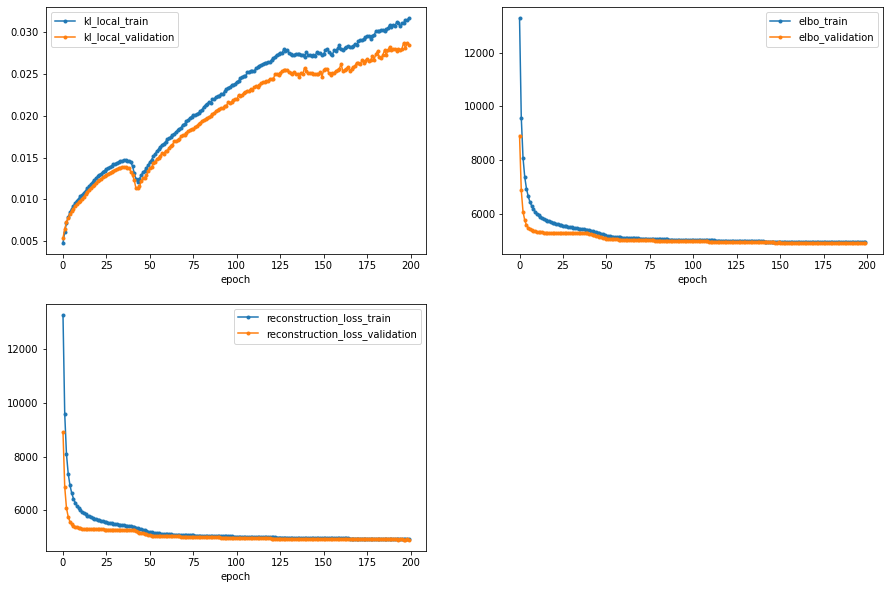

In [11]:
model.plot_losses()

# Inference

Get the latent representation.

In [12]:
model.get_latent_representation()
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_continuous', 'latent'
    layers: 'count', 'binary'

Visualize results.

... storing 'gene_ids' as categorical
... storing 'mt' as categorical
... storing 'highly_variable' as categorical


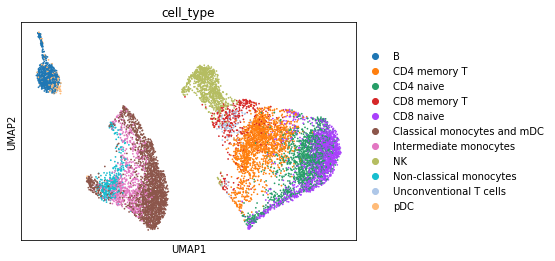

In [13]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')